## Select Top 1 molecules that has the specific properties for the task

In [1]:

import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
sys.path.append('/home/ianlee/JTVAE/JTVAE/CPU-P3')
from fast_jtnn import *

vocab_path = '/home/ianlee/JTVAE/Ian_train/Vocabulary/smi_vocab-2.txt'
model_path = '/home/ianlee/JTVAE/Ian_train/Train/MODEL-TRAIN-3/model.epoch-39'

# Load vocabulary
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab)

# Initial Step for VAE
vae_model = JTNNVAE(vocab, hidden_size=450, latent_size=32, depthT=3, depthG=20)
vae_model.load_state_dict(torch.load(model_path, map_location='cpu'))
vae_model.cpu()
vae_model.eval()

[18:17:51] WARNING: not removing hydrogen atom without neighbors


JTNNVAE(
  (jtnn): JTNNEncoder(
    (embedding): Embedding(1223, 450)
    (outputNN): Sequential(
      (0): Linear(in_features=900, out_features=450, bias=True)
      (1): ReLU()
    )
    (GRU): GraphGRU(
      (W_z): Linear(in_features=900, out_features=450, bias=True)
      (W_r): Linear(in_features=450, out_features=450, bias=False)
      (U_r): Linear(in_features=450, out_features=450, bias=True)
      (W_h): Linear(in_features=900, out_features=450, bias=True)
    )
  )
  (decoder): JTNNDecoder(
    (embedding): Embedding(1223, 450)
    (W_z): Linear(in_features=900, out_features=450, bias=True)
    (U_r): Linear(in_features=450, out_features=450, bias=False)
    (W_r): Linear(in_features=450, out_features=450, bias=True)
    (W_h): Linear(in_features=900, out_features=450, bias=True)
    (W): Linear(in_features=466, out_features=450, bias=True)
    (U): Linear(in_features=466, out_features=450, bias=True)
    (U_i): Linear(in_features=900, out_features=450, bias=True)
    (W_o)

In [10]:
today = datetime.date.today().strftime("%Y%m%d")

#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO', 'ABC']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9',  'PSO/round10']
methods = ['BO/round1', 'BO/round2', 'BO/round3', 'BO/round4','BO/round5','BO/round6', 'BO/round7', 'BO/round8', 'BO/round9',  'BO/round10']
methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6', 'Random/round7', 'Random/round8', 'Random/round9', 'Random/round10']

methods = ['PSO-re/round1', 'PSO-re/round2', 'PSO-re/round3', 'PSO-re/round4',  'PSO-re/round5',
'PSO-re/round6', 'PSO-re/round7', 'PSO-re/round8','PSO-re/round9',  'PSO-re/round10']


methods = ['ABC_T/round4', 'ABC_T/round5',
            'ABC_T/round6', 'ABC_T/round7', 'ABC_T/round8', 'ABC_T/round9', 'ABC_T/round10']

methods = [ 'ABC_T/round5',
            'ABC_T/round6', 'ABC_T/round7','ABC_T/round9']

subfolder = 'c2'

for method in methods:
    print(f"Processing {method} method...")
    folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/1_Preprocessing_for_Analysis/{method}/{subfolder}'  # 取得當前工作目錄
    folder_list = []

    for item in os.listdir(folder_path_cn):
        if os.path.isdir(os.path.join(folder_path_cn, item)) and item.startswith("Result"):
            folder_list.append(item)

    data = []
    for folder_name in folder_list:
        folder_path = os.path.join(folder_path_cn, folder_name)
        if os.path.exists(folder_path):
            file_list = [file for file in os.listdir(folder_path) if '.sh.o' in file]
            for file in file_list:
                print(f'Processing {file}')
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'r') as f:
                    file_content = f.read()
                parts = file_content.split('\n\n')
                iteration_details, rank_details = parts[-2], parts[-1]
                fitness_list = re.findall('Fitness: ([\de\.\+\-]+)', rank_details)
                fitness_list = list(map(float, fitness_list))
                ranks = rank_details.split("-------------------------")
                
                #read in every data that has rank 1-10
                best = 0
                for i in range(10):
                    #best_fitness_index = fitness_list.index(fitness_list[i])
                    rank_data = ranks[i].split('\n')
                    rank_data = [line.strip() for line in rank_data if line]
                    file_data = {
                        "Folder Name": folder_name,
                        "Smiles": rank_data[1].split(": ")[1].strip(),
                        "Fitness": rank_data[2].split(": ")[1].strip(),
                        "Reagent1_(ul)": rank_data[5].split(": ")[1].strip(),
                        "Reagent2_(ul)": rank_data[6].split(": ")[1].strip(),
                        "Reagent3_(ul)": rank_data[7].split(": ")[1].strip(),
                        "Reagent4_(ul)": rank_data[8].split(": ")[1].strip(),
                        "lab_code": rank_data[9].split(": ")[1].strip(),
                        "crystal_size": rank_data[11].split(": ")[1].strip()}
                    try:
                        vae_model.encode_latent_mean([file_data['Smiles']])
                        calc = Calculator(descriptors, ignore_3D=True)
                        smiles = (file_data['Smiles'])
                        mols = Chem.MolFromSmiles(smiles)
                        mordred_data = calc.pandas([mols])
                        mordred_data = mordred_data.dropna(axis='columns')
                        numeric_cols = mordred_data.select_dtypes(exclude='number')
                        mordred_data.drop(numeric_cols, axis=1, inplace=True)
                        #print(mordred_data.shape)
                        # 檢查每個列是否存在於 DataFrame 中
                        columns_exist = all(item in mordred_data.columns for item in ["ATSC5v", "AATSC5Z", "MATS8se"])

                        if columns_exist:
                            if best < 1:
                                data.append(file_data)
                                best = 1
                    except:
                        print(f"Error: {file_data['Smiles']}", "encode falied")      
                              
                #need to calculate the Mordred descriptors
        else:
            print(f"Folder '{folder_name}' does not exist.")

    df = pd.DataFrame(data)
    # modred feature calculating
    calc = Calculator(descriptors, ignore_3D=True)
    smiles_list = list(df['Smiles'])
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    mordred_df = calc.pandas(mols)
    
    cols_to_convert = ['ATSC5v', 'AATSC5Z', 'MATS8se']
    
    import pandas as pd
    df = pd.concat((df, mordred_df['ATSC5v'] ,mordred_df['AATSC5Z'], mordred_df['MATS8se']), axis=1)
    
    df[["crystal_size", "crystal_size_Std"]] = df["crystal_size"].str.split(",", expand=True).astype(float)
    df["Fitness"] = df["Fitness"].astype(float)  # 將 "Fitness" 欄位轉換為浮點數
    df = df.sort_values(by='Fitness', ascending=False)  # 根據 Fitness 值降序排序
    df.reset_index(drop=True, inplace=True)  # 重新設定索引
    df = df[['Folder Name', 'Smiles', 'Fitness', 'ATSC5v', 'AATSC5Z', 
            'MATS8se', 'Reagent1_(ul)', 'Reagent2_(ul)', 'Reagent3_(ul)', 'Reagent4_(ul)', 'lab_code',
            'crystal_size', 'crystal_size_Std']]
    df.dropna()
    
    if len(df)>10:
        #keep the top 10 rows
        df = df.head(10)
    df.to_csv(os.path.join(folder_path_cn, f"{today}pvk_Report.csv"), index=False)
    print(f"CSV file '{today}pvk_Report.csv' has been created.")

    # 找到重复的文件夹名
    duplicates = df[df.duplicated('Smiles')]
    print('Duplicate Smiles:',duplicates['Smiles'])

Processing ABC_T/round5 method...
Processing tmp.sh.o3957103


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

Processing tmp.sh.o3957105



100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

Processing tmp.sh.o3957106
Error: Cc1nc2c(c3c(Cc4ccccc4)oc(=O)n13)CC(C)C(=O)[NH2+]2 encode falied



[18:23:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Processing tmp.sh.o3957107


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Processing tmp.sh.o3957108


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

Processing tmp.sh.o3957109



100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Processing tmp.sh.o3957110


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

Processing tmp.sh.o3957111



100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

Processing tmp.sh.o3957112



100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Processing tmp.sh.o3957114


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

Processing tmp.sh.o3957115



100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Processing tmp.sh.o3957116


100%|██████████| 12/12 [00:00<00:00, 17.26it/s]


CSV file '20250808pvk_Report.csv' has been created.
Duplicate Smiles: Series([], Name: Smiles, dtype: object)
Processing ABC_T/round6 method...
Processing tmp.sh.o3957117


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

Processing tmp.sh.o3957118



100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Processing tmp.sh.o3957119


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

Processing tmp.sh.o3957120



100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Processing tmp.sh.o3957121


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Processing tmp.sh.o3957122


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

Error: Cc1c2c(nn1-c1ncccn1)c(N)nn1c(=O)ccnc21 encode falied
Error: CC(=O)c1cn2[nH]c3c(c2n1)C(=O)N1C(=O)NCC1C3 encode falied



[18:26:12] Can't kekulize mol.  Unkekulized atoms: 2 3 12 14 21
[18:26:12] Can't kekulize mol.  Unkekulized atoms: 7 8 9
100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Processing tmp.sh.o3957123



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Error: Cc1onc(C(C)[NH+]2Cc3c2c(Cl)n(C2CCc4ccccc42)c3Cl)c1C encode falied


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

Processing tmp.sh.o3957124



100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


Error: Cc1ncc2c(c1C)n1c([n+]2C)C2(CN(C)C=[NH+]2)[N+]2=C1C([NH3+])CC2 encode falied
Error: c1ccn2ncnc2c1 encode falied


[18:26:29] Can't kekulize mol.  Unkekulized atoms: 9
[18:26:29] Can't kekulize mol.  Unkekulized atoms: 0 1 2 7 8
100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Processing tmp.sh.o3957125


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Processing tmp.sh.o3957126


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

Processing tmp.sh.o3957127



100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Processing tmp.sh.o3957129


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Processing tmp.sh.o3957130


100%|██████████| 13/13 [00:00<00:00, 14.74it/s]


CSV file '20250808pvk_Report.csv' has been created.
Duplicate Smiles: Series([], Name: Smiles, dtype: object)
Processing ABC_T/round7 method...
Processing tmp.sh.o3957131


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Processing tmp.sh.o3957132


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

Processing tmp.sh.o3957133



100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Error: Cc1nnc(C2CCc3ccnn32)o1 encode falied


[18:27:54] Can't kekulize mol.  Unkekulized atoms: 8
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Processing tmp.sh.o3957135



100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

Processing tmp.sh.o3957136



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Processing tmp.sh.o3957137


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

Processing tmp.sh.o3957139



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Processing tmp.sh.o3957140


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

Processing tmp.sh.o3957141



100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

Processing tmp.sh.o3957142



100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

Processing tmp.sh.o3957143



100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

Error: Cc1cnc(-c2ncn3cncc(Cl)c23)c2[nH]ncc12 encode falied



[18:29:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 14
100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

Processing tmp.sh.o3957144



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

Error: C[NH+]1CCN(C2C=Cc3nccn3C2)C(N)(c2ccon2)C1 encode falied



[18:29:32] Can't kekulize mol.  Unkekulized atoms: 8
100%|██████████| 12/12 [00:00<00:00, 21.99it/s]


CSV file '20250808pvk_Report.csv' has been created.
Duplicate Smiles: Series([], Name: Smiles, dtype: object)
Processing ABC_T/round9 method...
Processing tmp.sh.o3957159


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

Error: CCOC(=O)c1ccc(C23N=C(OC)C=NC2=CCCN3Cc2sccc2C)o1 encode falied
Processing tmp.sh.o3957160



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

Processing tmp.sh.o3957162



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

Processing tmp.sh.o3957163
Error: CCC1=C(O)C(c2cc(N)ccn2)Cc2c3ccccc3cn21 encode falied
Error: CCC1=CC(COc2ccc3ccccc3n2)C(O)c2c3ccccc3cn21 encode falied



[18:30:12] Can't kekulize mol.  Unkekulized atoms: 14
[18:30:12] Can't kekulize mol.  Unkekulized atoms: 19
100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

Processing tmp.sh.o3957164



100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Processing tmp.sh.o3957165


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Processing tmp.sh.o3957166


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Processing tmp.sh.o3957167



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Processing tmp.sh.o3957169


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Processing tmp.sh.o3957170


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

Processing tmp.sh.o3957172



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Error: Cc1ncc2c(c1C)n1c([n+]2[O-])CCOCC1 encode falied



[18:31:29] Can't kekulize mol.  Unkekulized atoms: 9
100%|██████████| 11/11 [00:00<00:00, 14.66it/s]


CSV file '20250808pvk_Report.csv' has been created.
Duplicate Smiles: Series([], Name: Smiles, dtype: object)


# 計算真實值與預測值之間的差別

In [3]:
# from mordred import Calculator, descriptors
from sklearn.ensemble import RandomForestRegressor
# from rdkit.Chem import PandasTools
import pickle

In [4]:
def pvk_crystal_predict(df: pd.DataFrame, 
                        pvk_rfr: RandomForestRegressor, 
                        # pvk_rfc: RandomForestClassifier,
                        ):

    # scroe predict
    pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se']
    # pvk_score_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','ATSC5v','ATSC5pe']
    df_size = df[pvk_size_feature_list]
    # df_score = df[pvk_score_feature_list]

    # return pvk_rfr.predict(df_size), pvk_rfc.predict(df_score), df[pvk_size_feature_list], df[pvk_score_feature_list]
    return pvk_rfr.predict(df_size), df[pvk_size_feature_list]


In [5]:
size_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/pvkadditives/pvk_rfr_size.pkl'

with open(size_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

In [6]:
rf_regressor.feature_names_in_

array(['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)',
       'lab_code', 'ATSC5v', 'AATSC5Z', 'MATS8se'], dtype=object)

In [7]:
#葉子點數計算
leaf_counts = [Estimator.get_n_leaves() for Estimator in rf_regressor]
mean_leaves = np.mean(leaf_counts)
print(mean_leaves)

106.01


In [8]:
inital_csv = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Surrogate_Model/cycle0_new.csv')
size_array = inital_csv['crystal_size']
criteria = np.percentile(size_array, 100)
print(criteria)
size_array.max(), size_array.mean() 

1.6616891335497823


(1.6616891335497823, 0.6987617853408751)

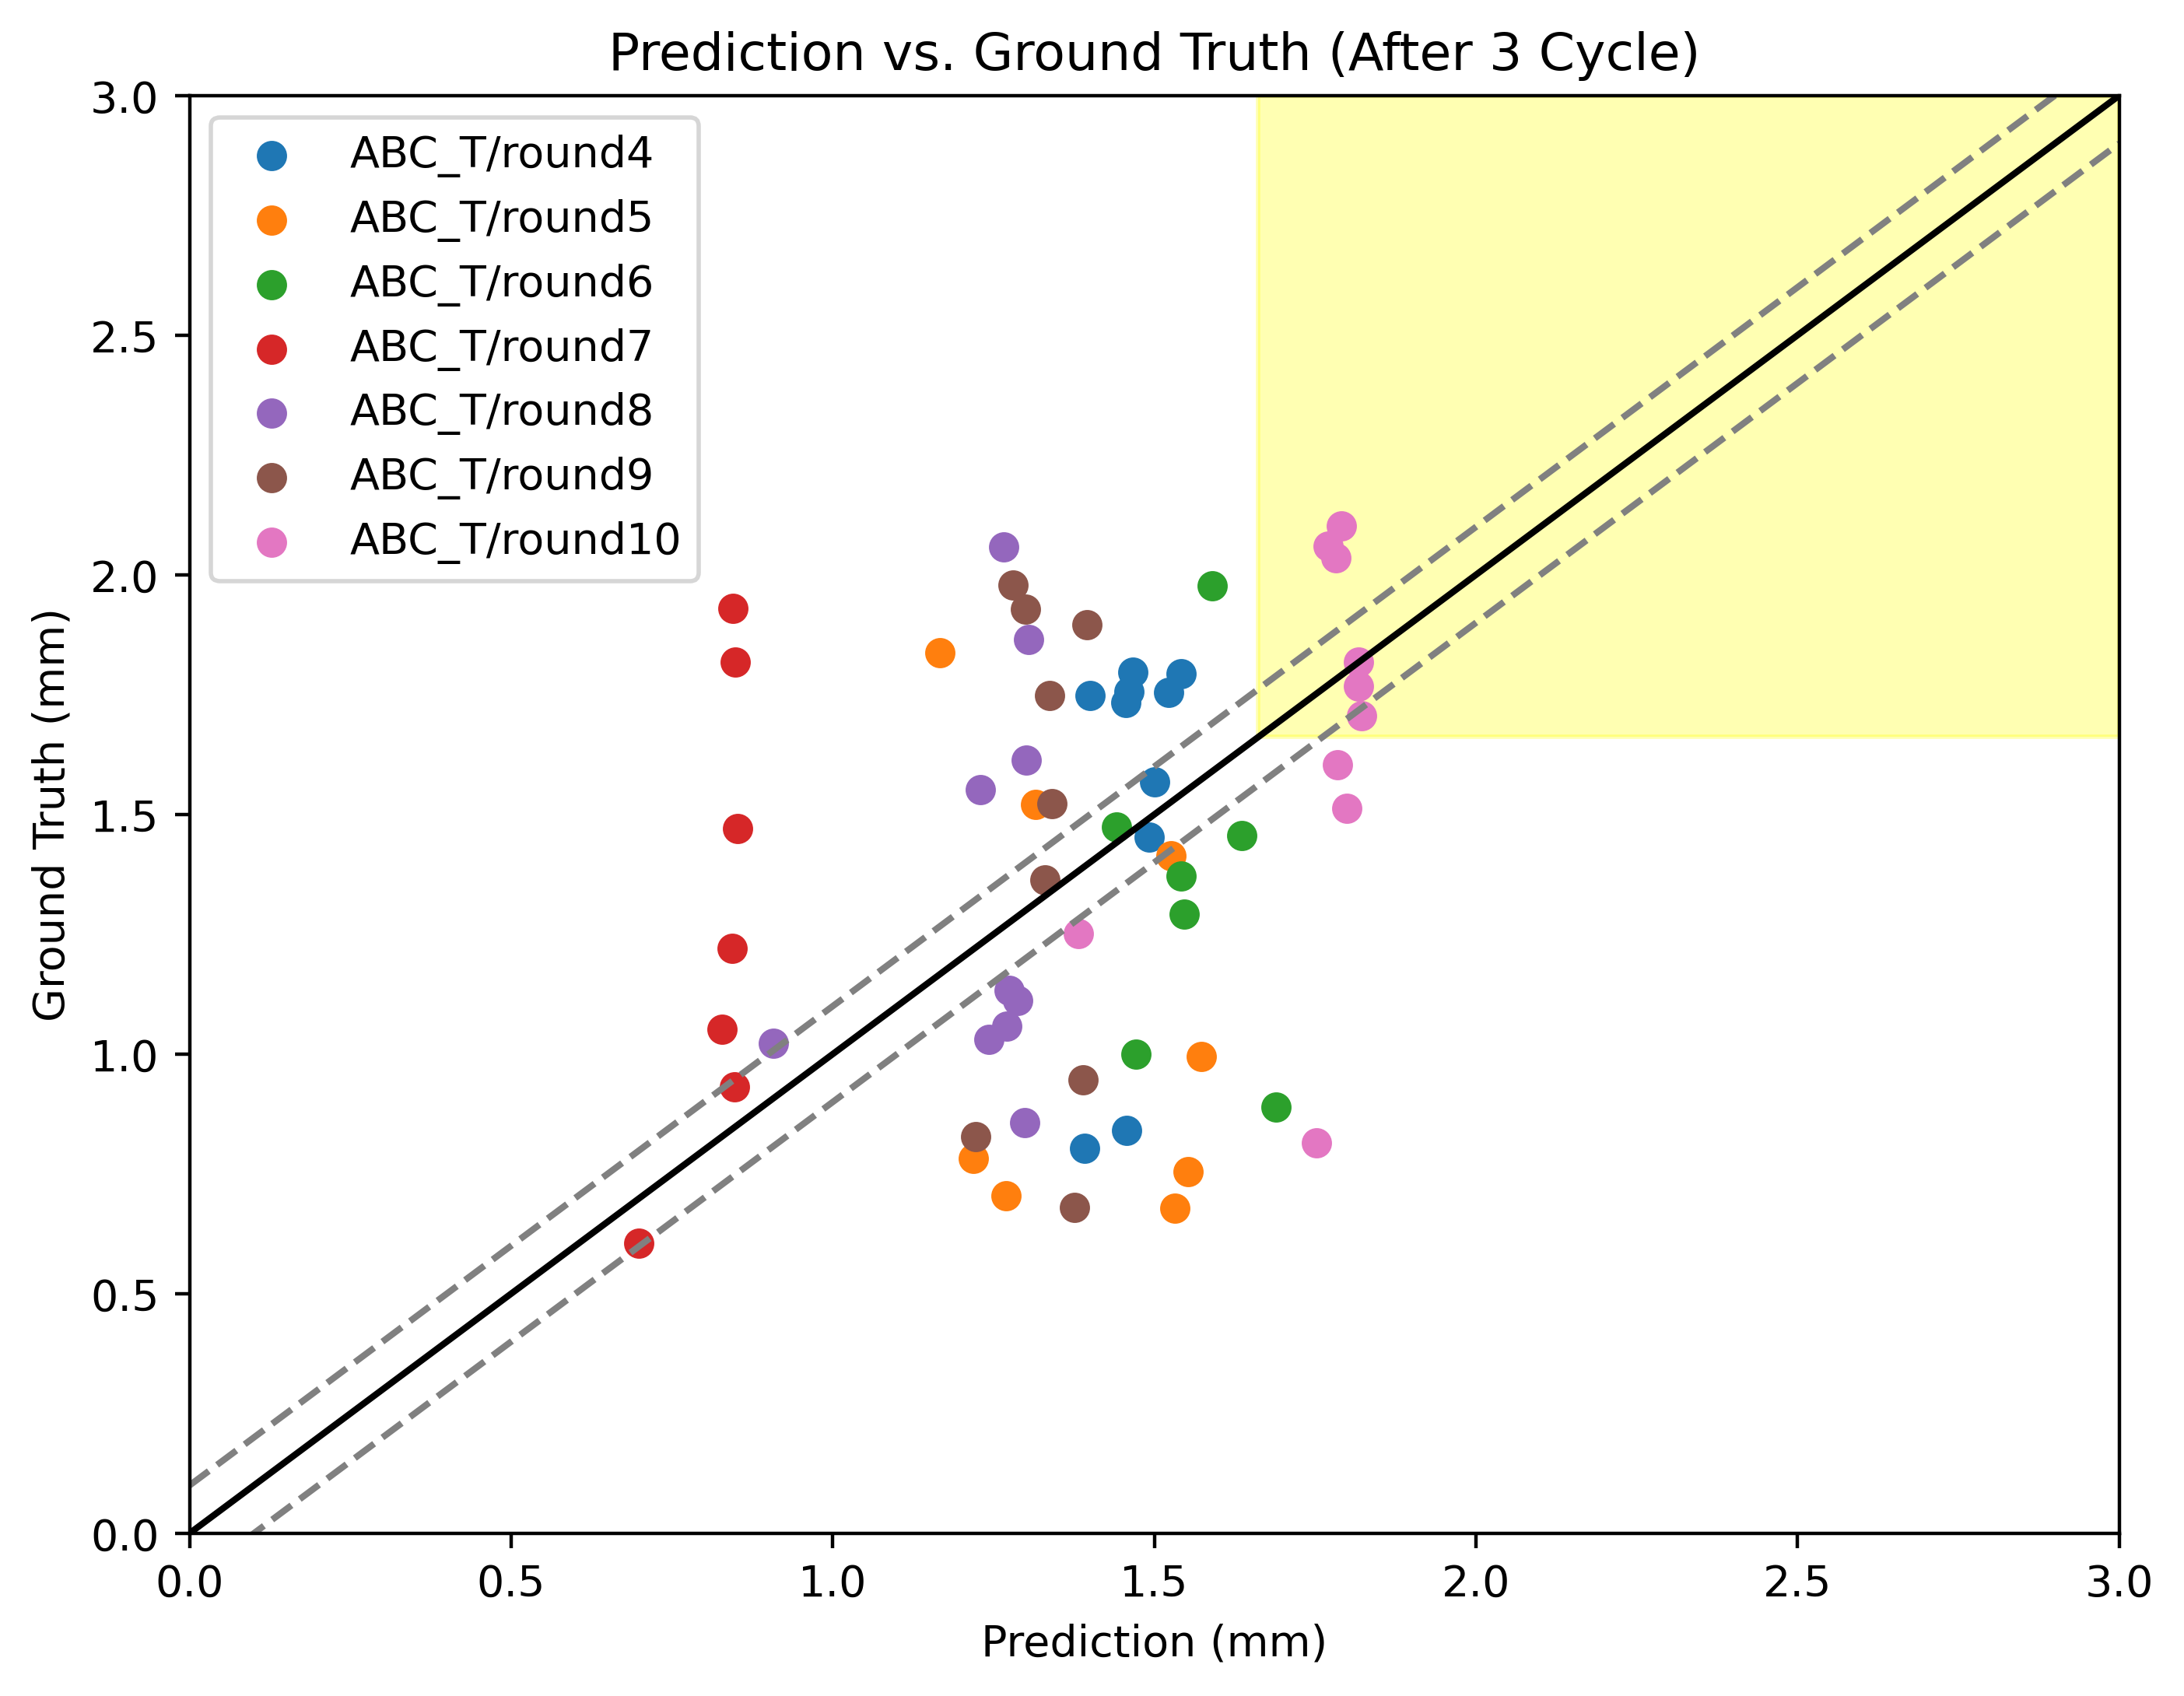

In [9]:
"""
目前對如何評價模型的效果還不是很確定，初步想法是在真實直上要很好並且希望模型的預測值跟實際值可以夠準
第一件事情：看找到的ground truth的平均 第二件事情：看模型的預測值跟ground truth的差距 怎麼樣平衡兩件事情
目前圖中的結果來說我們在margin範圍內預測值的比例有多高 可以先統計 並比較這些預測值內的平均值
但同時也要看誰能夠找到最好的分子 假設有人總有辦法在好多個cycle內都找到離群的優值 那我覺得這樣也是不錯
"""
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO','ABC']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9',  'PSO/round10']
methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6', 'Random/round7', 'Random/round8', 'Random/round9', 'Random/round10']

methods = ['PSO-re/round1', 'PSO-re/round2', 'PSO-re/round3', 'PSO-re/round4',  'PSO-re/round5',
'PSO-re/round6', 'PSO-re/round7', 'PSO-re/round8', 'PSO-re/round9',  'PSO-re/round10']

methods = ['ABC_T/round4', 'ABC_T/round5',
            'ABC_T/round6', 'ABC_T/round7', 'ABC_T/round8', 'ABC_T/round9', 'ABC_T/round10']

            
#methods = ['PSO-re/round1', 'PSO-re/round2', 'PSO-re/round3', 'PSO-re/round4',  'PSO-re/round5',
#'PSO-re/round6', 'PSO-re/round7', 'PSO-re/round8']

subfolder = 'c2'
today = datetime.date.today().strftime("%Y%m%d")

folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/1_Preprocessing_for_Analysis/SA/{subfolder}'  # 取得當前工作目錄

#methods = ['ABC', 'GA', 'PSO', 'SA']
#methods = ['ABC/10_iter']
colors = [
    "#1f77b4",  # 藍
    "#ff7f0e",  # 橙
    "#2ca02c",  # 綠
    "#d62728",  # 紅
    "#9467bd",  # 紫
    "#8c564b",  # 棕
    "#e377c2",  # 粉
    "#7f7f7f",  # 灰
    "#bcbd22",  # 橄欖
    "#17becf",  # 青
]


#colors = ['#EE6352']
domain_max, domain_min = 3.0, 0.0
#domain_max, domain_min = 2.0, 0.0

plt.figure(figsize=(8, 6), dpi=400)
plt.fill_betweenx([criteria, domain_max], criteria, domain_max, color='yellow', alpha=0.3)
for method, color in zip(methods, colors):
    new_folder_path_cn = folder_path_cn.replace('SA', method)
    file_path = os.path.join(new_folder_path_cn, f'{today}pvk_Report.csv')
    cyclen_pred = pd.read_csv(file_path)
    pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se', 'crystal_size']
    cyclen_pred = cyclen_pred.rename(columns={
    'Reagent1_(ul)': 'Reagent1 (ul)',
    'Reagent2_(ul)': 'Reagent2 (ul)',
    'Reagent3_(ul)': 'Reagent3 (ul)',
    'Reagent4_(ul)': 'Reagent4 (ul)', 
})  
    cyclen_pred = cyclen_pred[pvk_size_feature_list]
    size_features = cyclen_pred.apply(pd.to_numeric, errors='coerce')
    size_features_nonull = size_features.dropna()
    # print(cyclen_pred.columns)
    gt_prediction = pvk_crystal_predict(size_features_nonull, rf_regressor)[0]
    
    #save the prediction result to a new csv file
    # 繪製散點圖
    plt.scatter(size_features_nonull['crystal_size'], gt_prediction, color=color, label=method)



# 繪製對角線
x = np.linspace(domain_min, domain_max)
plt.plot(x, x, color='black')

# 設定x軸和y軸的範圍
plt.xlim(domain_min, domain_max)
plt.ylim(domain_min, domain_max)

# 繪製誤差範圍虛線
plt.plot(x, x + 0.1, color='gray', linestyle='dashed')
plt.plot(x, x - 0.1, color='gray', linestyle='dashed')

# 在圖形上添加文字
# plt.text(1.3, 1.8, 'Underestimate', fontsize=12)
# plt.text(1.7, 1.25, 'Overestimate', fontsize=12)
plt.title(f'Prediction vs. Ground Truth (After {int(subfolder[1]) + 1} Cycle)')
plt.xlabel('Prediction (mm)')
plt.ylabel('Ground Truth (mm)')
plt.legend()
plt.show()